# Locationing Lab 2: Computing Distances

### EE16A: Designing Information Devices and Systems I

**Name 1:**

**Login:** ee16a-

**Name 2:**

**Login:** ee16a-

####[Pre-Lab Presentation](https://docs.google.com/presentation/d/15U-ukuIrtQCyeOJFDSt08PSDi2eP4GHIdJMPPZ5qVKk/edit?usp=sharing)
####[Introduction](#w2)
####[Task 0: Importing Code](#task0)
####[Task 1: Separating Signals](#task1)
####[Task 2: Computing Distances](#task2)
####[Task 3: Testing with the Microphone](#task3)

<a id='w2'></a>
##Introduction

Last week we learned how to use a powerful tool, cross-correlation, to extract information from the received signal. In this week's lab, you will continue to process the information you have extracted last week, and do some locationing! Just like last week's lab you will focus first on implementing and testing, and it may be confusing. Feel free to ask when you are stuck (you are not alone!), and use plots and visualizations to help yourself understand the material! The block diagram below illustrates the locationing process flow we'll implement in this lab.

<center>
<img src="http://inst.eecs.berkeley.edu/~ee16a/images/location_img/wk1_block_diagram.png" align="center" style="height:450px">
</center>

In [1]:
%pylab inline
from __future__ import division
import random
import math

# Importing helper functions
%run support_code/virtual.py
%run support_code/signals.py
%run support_code/demod.py

Populating the interactive namespace from numpy and matplotlib


<a id='task0'></a>
# <span style="color:blue">Task 0: Importing Week 1 Code</span>

This lab will require you to use two of the three functions you implemented last week.
<br/>
**<span style="color:red">
Use the built-in `cross_correlation` function and paste your `identify_peak` function into the cell below.

In [22]:
# Copy the functions from week 1 below
def cross_correlation(signal1, signal2):
    """Compute the cross_correlation of two given signals    
    Args:
    signal1 (np.array): input signal 1
    signal2 (np.array): input signal 2
    
    Returns:
    cross_correlation (np.array): cross-correlation of signal1 and signal2
    
    >>> cross_correlation([0, 1, 2, 3, 3, 2, 1, 0], [0, 2, 3, 0])
    [0, 0, 3, 8, 13, 15, 12, 7, 2, 0, 0]
    >>> cross_correlation([0, 2, 3, 0], [0, 1, 2, 3, 3, 2, 1, 0])
    [0, 0, 2, 7, 12, 15, 13, 8, 3, 0, 0]
    
    The for loops implemented in our custom cross-correlation function from
    last week results in lengthy computation times for the audio signals we're
    going to deal with, so we'll use the faster built-in cross correlation
    python function.
    """
    return numpy.convolve(signal1, signal2[::-1])

def identify_peak(signal):
    """Returns the index of the peak of the given signal.
    Args:
    signal (np.array): input signal
    
    Returns:
    index (int): index of the peak
    
    >>> identify_peak([1, 2, 5, 7, 12, 4, 1, 0])
    4
    >>> identify_peak([1, 2, 2, 199, 23, 1])
    3
    """
    return np.argmax(signal)

<a id='task1'></a>
# <span style="color:blue">Task 1: Separating Beacons</span>

Recall from the last week's lab: even though we only have a single microphone receiving signals from multiple beacons, we can use *cross-correlation* to determine the time (in samples) at which each signal arrives. We call this process *separating signals*.

<center>
<img src="http://www-inst.eecs.berkeley.edu/~ee16a/sp15/Labs/location/nb_img/wk2_separated.png" style="height:256px" />
</center>

**<span style="color:red">Complete the `separate signal` function.</span>**

In [9]:
# A list of simulated beacons has been imported already. Any code requiring the original beacons can just use this. 
beacon

[array([1, 1, 1, ..., 1, 1, 1], dtype=int16),
 array([ 1,  1,  1, ..., -1, -1, -1], dtype=int16),
 array([ 1,  1,  1, ..., -1, -1, -1], dtype=int16),
 array([ 1,  1,  1, ..., -1, -1, -1], dtype=int16),
 array([ 1,  1,  1, ..., -1, -1, -1], dtype=int16),
 array([ 1,  1,  1, ..., -1, -1, -1], dtype=int16)]

In [29]:
def separate_signal(raw_signal):
    """Separate the beacons by computing the cross correlation of the raw signal 
    with the known beacon signals.
    
    Args:
    raw_signal (np.array): raw signal from the microphone composed of multiple beacon signals
    
    Returns (list): each entry should be the cross-correlation of the signal with one beacon
    """
    return [cross_correlation(list(raw_signal), list(one_beacon)) for one_beacon in beacon]

Before we move on to converting these time differences into locations, we first need to consider several potential issues with our locationing system. 

1. Our beacons are being played repeatedly at a fixed rate, however we don't know when in the sequence of beacons we started recording. For example, if we record exactly the number of samples of a beacon, we may have begun recording after some of the beacon signals reached the microphone.
<br/><br/>
2. The microphone uses a buffer to allow it to output data to the computer at the appropriate rate when the recording function is called. When recording samples are first saved to this buffer, and unfortunately when we first start recording, we don't know what it contains. This is why you may have only seen your signal "start" at a certain time as shown below.
<br/><br/>
3. You may have noticed last week that the height of the peaks in your final output was dependent on the volume of the speakers. Just like all of the other systems, the output will be affected by noise which in this case is literally other sounds in the room. 
<br/>
<center>
<img src="http://www-inst.eecs.berkeley.edu/~ee16a/sp15/Labs/location/nb_img/wk2_buffer.png" style="height:256px" />
**The low amplitude values before sample 10,000 correspond to values read from the buffer prior to recording the real signal.** 
</center>
<br/>

The beacon signals repeat every 230 ms, and we record for approximately 2.5 s. Because of this we are recording the *same* beacon signals multiple times, and assuming our object isn't moving we only need *one* set of measurements to determine the time differences between them. 

**<span style="color:red">How can we use our full recorded signal to solve the problems explained above and make our system more robust? Hint: We only need one recording of the beacon signals, but we wind up with many repeats. How can we use this 'extra' information to our advantage.</span>**


**<span style="color:red">We have implemented a function that makes this improvement below. Make sure you can explain what each line of code is doing for checkoff.</span>**

In [30]:
def average_signal(separated):
    """Takes the cross-correlation of the received signal with a beacon (written here as 
    separated), divides it into periodic slices and averages these slices in order to 
    increase the signal-to-noise ratio.
    
    Args:
    separated (np.array): cross-correlation of the received signal with a beacon.
    
    Returns (np.array): average of periodic slices of separated (our input)
    """
    beacon_length = len(beacon0)
    num_repeat = len(separated) // beacon_length
    averaged = np.mean(np.abs(separated[0 : num_repeat * beacon_length]).reshape((num_repeat, beacon_length)), 0)
    return averaged

def signal_generator(x, y, noise=0):
    raw_signal = add_random_noise(simulate_by_location(x, y), noise)
    return demodulate_signal(raw_signal)

**<span style="color:red">Run the code below to plot how the quality of the signal improves after running this function.</span>**
<br/>
Note: Each of these blocks deals with >100k samples, so they may take several seconds to run.

In [31]:
test_signal = signal_generator(1.2, 3.4, noise=25)
sig = separate_signal(test_signal)

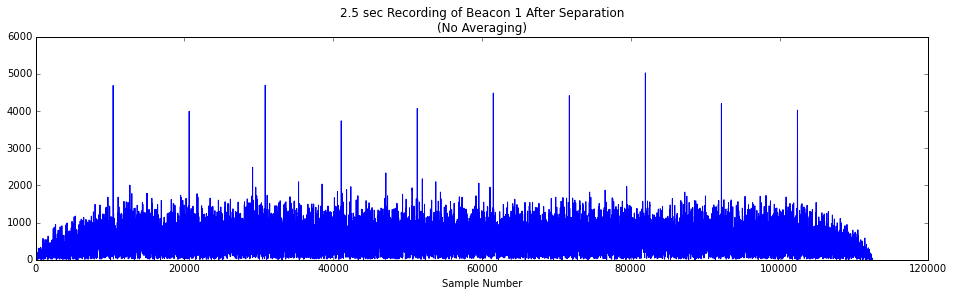

In [32]:
plt.figure(figsize=(16,4))
plt.plot(np.abs(sig[1]))

plt.title('2.5 sec Recording of Beacon 1 After Separation\n(No Averaging)')
plt.xlabel('Sample Number')
plt.show()

In [33]:
avg = [average_signal(s) for s in sig]

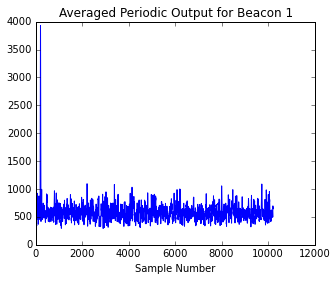

In [34]:
plt.figure(figsize=(5,4))
plt.plot(avg[1])
plt.title('Averaged Periodic Output for Beacon 1')
plt.xlabel('Sample Number')
plt.show()

**<span style="color:red">What is the effect of averaging? Why would this be useful?</span>**

Adding the slices together ensures positive interference at the "spikes" in the cross correlation while having noise stay about the same, so when averaged the "spike" to baseline noise ratio will be much higher. This makes it less likely for the spike to be lost in the noise.

<a id='task2'></a>
# <span style="color:blue">Task 2a: Computing Distances</span>

We can now determine the time at which each signal arrived with respect to the first sample of the recording. Unfortunately, this time in samples has no direct relationship to physical distances. As discussed above, our recordings start at arbitrary times with respect to the beacons. However, we can compute times relative to a particular beacon.

For example, if our cross-correlation tells us that **`beacon0`** arrives at $t_0 = 1120$ and **`beacon1`** arrives at $t_1 = 1420$ we can see that **`beacon1`** arrives $300$ samples after **`beacon0`**.
We call the relative time of arrival in samples **offsets** and define the **offset** of all other beacons with respect to **`beacon0`**.

**<span style="color:red">According to our definition above what is the offset of `beacon0`?</span>**

$0$

**<span style="color:red">If `beacon2` arrives 450 samples later than `beacon0`, what is the *time* difference of arrival (in seconds) given that our sampling rate is $f_s=44100$ Hz?</span>**

$\frac{450}{44100 \textrm{ Hz}} \approx 0.010204 \textrm{ seconds} \approx 10.2 \textrm{ ms}$

**<span style="color:red">Run the code below to plot the separated signals. Can you estimate the offset for each signal relative to `beacon 0`?</span>**


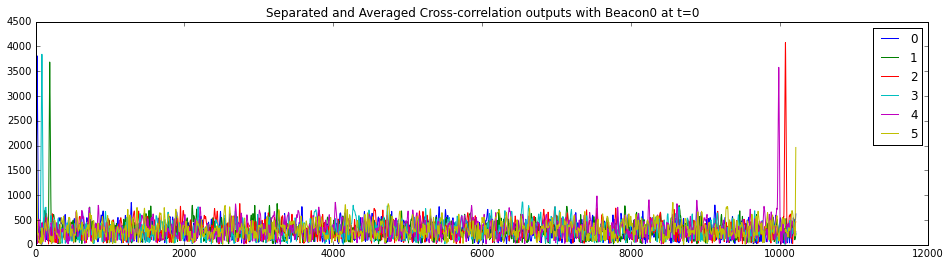

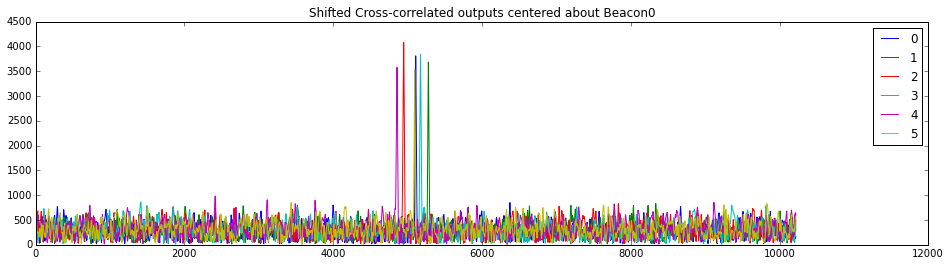

In [35]:
# Simulate the received signal
test_signal = signal_generator(1.4, 3.22)

# Separate the beacon signals by demodulating the received signal
separated = separate_signal(test_signal)

# Perform our averaging function
avg = [average_signal(s) for s in separated]

# Plot the averaged output for each beacon
plt.figure(figsize=(16,4))
for i in range(len(avg)):
    plt.plot(avg[i], label="{0}".format(i))
plt.title("Separated and Averaged Cross-correlation outputs with Beacon0 at t=0")
plt.legend()
plt.show()

# Plot the averaged output for each beacon centered about beacon0
plt.figure(figsize=(16,4))
peak = identify_peak(avg[0])
for i in range(len(avg)):
    plt.plot(np.roll(avg[i], len(avg[0]) // 2 - peak), label="{0}".format(i))
plt.title("Shifted Cross-correlated outputs centered about Beacon0")
plt.legend()
plt.show()

Note that sometimes a beacon can arrive earlier than our reference signal, **`beacon0`**. More intuitively, these beacons have a *negative offset*. You can think of this as the plot being a defined number of samples and the end wrapping around to represent negative values.
We have provided you code to center the received signal about **`beacon0`** at sample 0 as done in the two plots above.

**<span style="color:red">Complete the function below which returns offsets in samples given a list of input signals.</span>**

In [41]:
def identify_offsets(averaged):
    """ Identify the difference in samples between the samples.
    The peaks of the signals are shifted to the center.
    
    Args:
    averaged (list): a python list in which each entry is a numpy array 
                    from the output of average_signal (look above to find 
                    out more about average_signal)
    
    Returns (list): a list corresponding to the offset of each signal in the input
    """
    # Reshaping (shifting) the input so that all of our peaks are centered about the peak of beacon0
    peak = identify_peak(averaged[0])
    shifted = [np.roll(avg, len(averaged[0]) // 2 - peak) for avg in averaged]
    ##### DO NOT CHANGE THE CODE ABOVE THIS LINE ####
    
    # SHIFTED represents all of the signals shifted so that they are centered about the peak of beacon0
    # Use SHIFTED to determine the offsets
    # Consider what the offset for beacon0 should be

    return [identify_peak(shifted_term) - len(averaged[0]) // 2 for shifted_term in shifted]

We now need to convert the offsets we have computed in samples to the time difference of arrivals (TDOAs) we will use to determine locations.

**<span style="color:red">Given that our microphones sample at a rate of $f_s=44100$ Hz, complete the function `offset_to_time` below which takes a list of offsets (for example the output of `identify_offsets`), and a sampling frequency and returns a list of TDOA's.</span>**
<br/>
*Hint: What is the relation between sampling frequency, number of samples, and time?*

In [57]:
def offset_to_time(offsets, sampling_freq=44100):
    """ Convert a list of offsets to a list of TDOA's
   
    Args:
    offsets (list): list of offests in samples
    sampling_freq (int): sampling frequency in Hz
    
    Returns (list): a list of TDOAs corresponding to the input offsets
    """
    return [offset / sampling_freq for offset in offsets]

# <span style="color:blue">Task 2b: Combining Functions</span>
We now have a variety of helper functions to perform each step of the calculations required to go from our microphone signal to a list TDOAs with all the relevant intermediate steps.

**<span style="color:red">Implement a function that will take in the recorded microphone signal and output the offset in *samples*.</span>**

In [48]:
def signal_to_offsets(raw_signal):
    """ Compute a list of offsets from the microphone to each speaker.
    
    Args:
    raw_signal (np.array): raw received signal from the microphone (e.g. no separation, averaging, etc).
    
    Returns (list): offset for each beacon (beacon0, beacon1, etc). in samples
    """
    return identify_offsets([average_signal(s) for s in separate_signal(raw_signal)])

We now know the time differences relative to a single beacon, so given a reference time for **`beacon0`** we can determine the total time for the sound wave to travel the distance from the speakers to our microphone. Knowing that the speed of sound is **340 m/s**, we can compute the distance from the microphone to each speaker, and use simple geometry to locate ourselves! This is exactly what the GPS is doing, except with electromagnetic waves rather than sound waves.

**<span style="color:red">Implement a function, `signal_to_distances`, which takes a recorded signal and the time of arrival of the first beacon signal, and returns a list of the distance from the microphone to each speaker.</span>**
*Hint: You may wish to take advantage of a function that computes the offsets given the raw microphone signal.*


In [62]:
v_air = 340.29
def signal_to_distances(raw_signal, t0):
    """ Returns a list of distancs from the microphone to each speaker.
    
    Args:
    signal (np.array): recorded signal from the microphone
    t0 (float): reference time for beacon0 in seconds
    
    Returns (list): distances to each of the speakers (beacon0, beacon1, etc). in meters
    """
    return [v_air * (time + t0) for time in offset_to_time(signal_to_offsets(raw_signal))]

**<span style="color:red">Run the following tests and make sure that all four tests pass before moving on to the example section.</span>**

In [63]:
# Virtual Test

# Utility Functions
def list_float_eq(lst1, lst2):
    if len(lst1) != len(lst2): return False
    for i in range(len(lst1)):
        if abs(lst1[i] - lst2[i]) >= 0.00001: return False
    return True

def list_sim(lst1, lst2):
    if len(lst1) != len(lst2): return False
    for i in range(len(lst1)):
        if abs(lst1[i] - lst2[i]) >= 3: return False
    return True

test_num = 0

# 1. Identify offsets - 1
print(" ------------------ ")
test_num += 1
test_signal = get_signal_virtual(offsets = [0, 254, 114, 22, 153, 625])
raw_signal = demodulate_signal(test_signal)
sig = separate_signal(raw_signal)
avg = [average_signal(s) for s in sig]
offsets = identify_offsets(avg)
test = list_sim(offsets, [0, 254, 114, 23, 153, 625])
print("Test positive offsets")
print("Your computed offsets = {}".format(offsets))
print("Correct offsets = {}".format([0, 254, 114, 23, 153, 625]))
if not test:
    print(("Test {0} Failed".format(test_num)))
else: 
    print("Test {0} Passed".format(test_num))

# 2. Identify offsets - 2
print(" ------------------ ")
test_num += 1
test_signal = get_signal_virtual(offsets = [0, -254, 0, -21, 153, -625])
raw_signal = demodulate_signal(test_signal)
sig = separate_signal(raw_signal)
avg = [average_signal(s) for s in sig]
offsets = identify_offsets(avg)
test = list_sim(offsets, [0, -254, 0, -21, 153, -625])
print("Test negative offsets")
print("Your computed offsets = {}".format(offsets))
print("Correct offsets = {}".format([0, -254, 0, -21, 153, -625]))
if not test:
    print("Test {0} Failed".format(test_num))
else: 
    print("Test {0} Passed".format(test_num))

# 3. Offsets to TDOA
print(" ------------------ ")
test_num += 1
off2t = offset_to_time([0, -254, 0, -21, 153, -625], 44100)
test = list_float_eq(np.around(off2t,6), np.around([0.0, -0.005759637188208617, 0.0, -0.0004761904761904762, 0.0034693877551020408, -0.01417233560090703],6))
print("Test TDOAs")
print("Your computed TDOAs = {}".format(np.around(off2t,6)))
print("Correct TDOAs = {}".format(np.around([0.0, -0.005759637188208617, 0.0, -0.0004761904761904762, 0.0034693877551020408, -0.01417233560090703],6)))
if not test:
    print("Test {0} Failed".format(test_num))
else: 
    print("Test {0} Passed".format(test_num))

# 4. Signal to distances
print(" ------------------ ")
test_num += 1
dist = signal_to_distances(demodulate_signal(get_signal_virtual(x=1.765, y=2.683)), 0.009437530220245524)
test = list_float_eq(np.around(dist,1), np.around([3.2114971586473495, 4.1991869545657172, 2.9105604239534717, 3.9754134851779623, 1.7762604239534723, 2.7870991994636762],1))
print("Test computed distances")
print("Your computed distances = {}".format(np.around(dist,1)))
print("Correct distances = {}".format(np.around([3.2114971586473495, 4.1991869545657172, 2.9105604239534717, 3.9754134851779623, 1.7762604239534723, 2.7870991994636762],1)))
if not test:
    print("Test {0} Failed".format(test_num))
else: 
    print("Test {0} Passed".format(test_num))

 ------------------ 
Test positive offsets
Your computed offsets = [0, 254, 114, 21, 153, 625]
Correct offsets = [0, 254, 114, 23, 153, 625]
Test 1 Passed
 ------------------ 
Test negative offsets
Your computed offsets = [0, -254, 0, -21, 153, -626]
Correct offsets = [0, -254, 0, -21, 153, -625]
Test 2 Passed
 ------------------ 
Test TDOAs
Your computed TDOAs = [ 0.       -0.00576   0.       -0.000476  0.003469 -0.014172]
Correct TDOAs = [ 0.       -0.00576   0.       -0.000476  0.003469 -0.014172]
Test 3 Passed
 ------------------ 
Test computed distances
Your computed distances = [ 3.2  4.2  2.9  4.   1.8  2.8]
Correct distances = [ 3.2  4.2  2.9  4.   1.8  2.8]
Test 4 Passed


After computing the distances from each speaker, we can use the formula for distance $d = \sqrt{(x-x_{speaker})^2 + (y-y_{speaker})^2}$ to construct a system of equations and solve for our exact location! Rather than solving for our exact coordinates, we will visualize our position with respect to the beacons on a graph.

**<span style="color:red">Add the necessary lines of code then run the following block that separates, averages and shifts five location beacon signals with respect to a `beacon0` on a 2D plane with our microphone located at (1.2, 3.6).</span>**

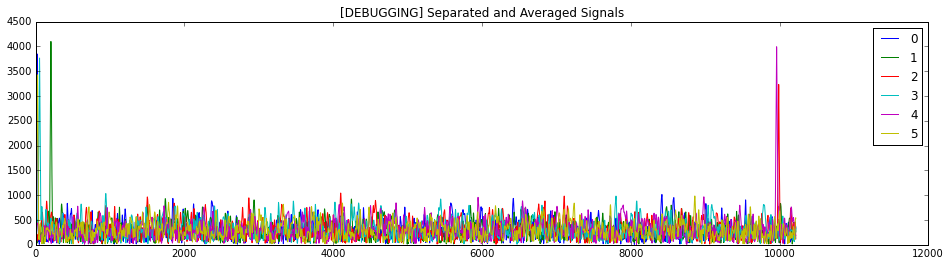

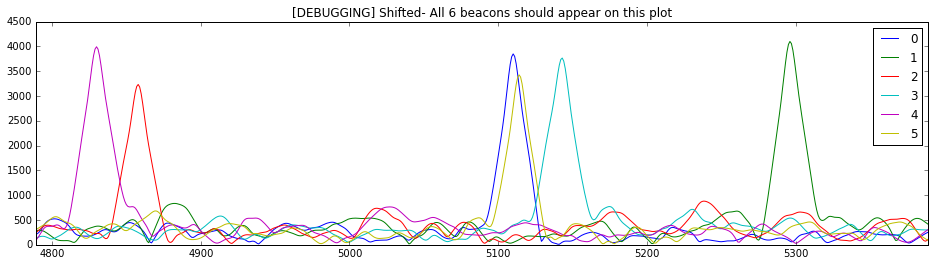

[DEBUGGING] The offsets are: [0, 186, -252, 33, -280, 4]


In [67]:
# Assume the time of arrival of the first beacon is 0.011151468430462413.
received_signal = get_signal_virtual(x=1.2, y=3.6)
raw_signal = demodulate_signal(received_signal)

# BEGIN SOLUTION
# Separate the beacon signals

# Perform our averaging function, the output should be called avgf
avgf = [average_signal(s) for s in separate_signal(raw_signal)]
# END SOLUTION

# Plot the averaged output for each beacon
plt.figure(figsize=(16,4))
for i in range(len(avgf)):
    plt.plot(avgf[i], label="{0}".format(i))
plt.title("[DEBUGGING] Separated and Averaged Signals")
plt.legend()
plt.show()

# Plot the averaged output for each beacon centered about beacon0
plt.figure(figsize=(16,4))
peak = identify_peak(avgf[0])
for i in range(len(avgf)):
    plt.plot(np.roll(avgf[i], len(avgf[0]) // 2 - peak), label="{0}".format(i))
plt.title("[DEBUGGING] Shifted- All 6 beacons should appear on this plot")
plt.xlim(len(avgf[0]) // 2 - peak - 300, len(avgf[0]) // 2 - peak + 300)
plt.legend()
plt.show()

offsets = signal_to_offsets(raw_signal)
print( "[DEBUGGING] The offsets are: %s"%str(offsets))

**<span style="color:red">Run the following block to simulate speakers located at (0, 0), (5, 0), (0, 5) on a 2D plane and a microphone located at (1.2, 3.6).</span>**

The distances are: [3.7947331922020551, 5.2299699268959321, 1.850218906487769]


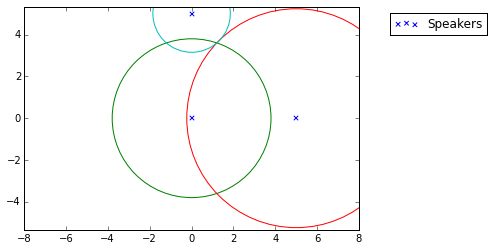

In [68]:
distances = signal_to_distances(raw_signal, 0.011151468430462413)
distances = distances[:3]
print( "The distances are: %s"%str(distances))

# Plot the speakers
coords = [(0, 0), (5, 0), (0, 5)]

plot_speakers(plt, coords, distances, xlim=(-8, 8), ylim=(-16/3, 16/3))
plt.show()

**<span style="color:red">What do you observe? What does each circle mean? What about their intersections?</span>**

Answer: The circles (which represent possible locations given one signal) intersect at one point. This intersection is our location






Now let's explore how the number of speakers (beacon signals) affect our solution. First, let's try the exact same code with one fewer beacon signal (so we only have two beacons and the time of arrival of the first one):

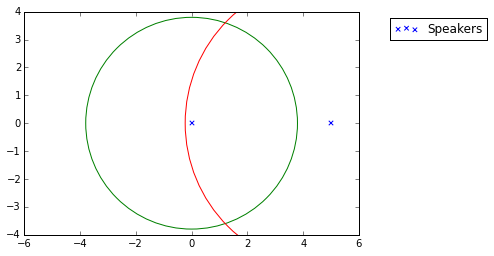

In [69]:
# Assume the time of arrival of the first beacon is 0.011151468430462413.
plot_speakers(plt, [(0, 0), (5, 0)], distances, xlim=(-6, 6), ylim=(-4, 4))
plt.show()

**<span style="color:red">How many dimensions can we determine our position in? For our goal of a 2D locationing system what is the minimum number of beacons we will need?</span>**


Now let's do it with five beacons:

The distances are: [3.7947331922020551, 5.2299699268959321, 1.850218906487769, 4.0493719677122586, 1.6341617636306263]


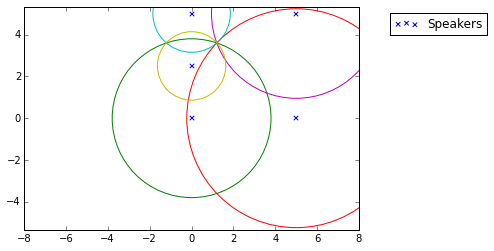

In [70]:
# Assume the time of arrival of the first beacon is 0.011151468430462413.
received_signal = get_signal_virtual(x=1.2, y=3.6)
raw_signal = demodulate_signal(received_signal)
distances = signal_to_distances(raw_signal, 0.011151468430462413)
distances = distances[:5]
print(("The distances are: " + str(distances)))

# Plot the speakers
plot_speakers(plt, [(0, 0), (5, 0), (0, 5), (5, 5), (0, 2.5)], distances, xlim=(-8, 8), ylim=(-16/3, 16/3))
plt.show()

**<span style="color:red">We know we need a minimum number of beacons to find our location uniquely in a 2D space. How could additional beacons be useful? List two reasons.</span>**

We can now locate ourselves if we know the time of arrival of the first beacon. How can we do it without knowing any time of arrival? In next week's lab, we will find a way to do the locationing using only time difference of arrival (TDOA's)!


***<span style="color:red">IMPORTANT, SAVE YOUR FUNCTIONS!!!: *** **Save your ipython notebook into the cloud or a personal drive. You will need to paste certain functions in next week's notebook just as you did for this week.**

<a id='task3'></a>
# <span style="color:blue">Task 3: Testing With the Microphone</span>
**<span style="color:red">MAKE SURE THE MICROPHONE AND SPEAKERS ARE CONNECTED</span>**

In [79]:
%run support_code/rec.py

def get_signal():
    """Get the signal from the microphone"""
    return mic.new_data()

Play **offset_250_540_-321.wav** in the lab folder and use your microphone to record it (by running the cell below - you may want to run it twice when the wav file is playing to *clear the buffer*.

In [80]:
received_signal = get_signal()

Again, plot the signal to make sure it is properly recorded before you use it to test your code.

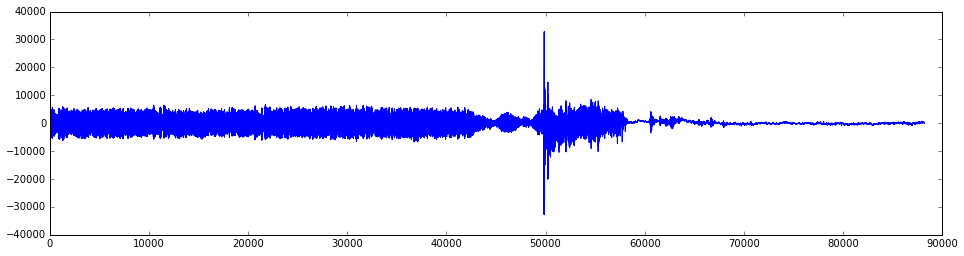

In [81]:
plt.figure(figsize=(16,4))
plt.plot(received_signal)
plt.show()
plt.savefig("buffer1.png")

In [82]:
# Test your code:
offsets = signal_to_offsets(demodulate_signal(received_signal))
print("Expected: " + str([0, 250, 540, -321]))
print("Got: " + str(offsets[:4]))

Expected: [0, 250, 540, -321]
Got: [0, 252, 541, -320]
